# Load and prepare data

In [1]:
import pandas as pd
import numpy as np
import cv2

from tqdm import tqdm

import os

import matplotlib.pyplot as plt

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [2]:
# Loads labels
df = pd.read_csv("seedling_labels.csv")

df.head(10)

,Expert 1,Expert 2,Expert 3,Expert 4,color_cam_path,side_cam_path,Rfid,Pos,Majority Vote,Binary Classification,Unnamed: 10
0,4,4,4,4,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1/00387 Plant 0000 Plant 0000/18-02-2019 -- 1...,A1,Plant 0000,4,0,"0 -Abnormal plant ,1- Normal plant"
1,1,1,1,1,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1/00388 Plant 0001 Plant 0001/18-02-2019 -- 1...,A1,Plant 0001,1,1,NaN
2,1,1,1,1,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1/00389 Plant 0002 Plant 0002/18-02-2019 -- 1...,A1,Plant 0002,1,1,NaN
3,4,4,3,3,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1/00390 Plant 0003 Plant 0003/18-02-2019 -- 1...,A1,Plant 0003,3,0,NaN
4,3,1,1,1,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1/00391 Plant 0004 Plant 0004/18-02-2019 -- 1...,A1,Plant 0004,1,1,NaN
5,3,3,3,3,A1/00392 Plant 0005 Plant 0005/18-02-2019 -- 1...,A1/00392 Plant 0005 Plant 0005/18-02-2019 -- 1...,A1,Plant 0005,3,0,NaN
6,1,3,3,3,A1/00393 Plant 0006 Plant 0006/18-02-2019 -- 1...,A1/00393 Plant 0006 Plant 0006/18-02-2019 -- 1...,A1,Plant 0006,3,0,NaN
7,1,1,1,1,A1/00394 Plant 0007 Plant 0007/18-02-2019 -- 1...,A1/00394 Plant 0007 Plant 0007/18-02-2019 -- 1...,A1,Plant 0007,1,1,NaN
8,1,1,1,1,A1/00395 Plant 0008 Plant 0008/18-02-2019 -- 1...,A1/00395 Plant 0008 Plant 0008/18-02-2019 -- 1...,A1,Plant 0008,1,1,NaN
9,1,1,1,1,A1/00396 Plant 0009 Plant 0009/18-02-2019 -- 1...,A1/00396 Plant 0009 Plant 0009/18-02-2019 -- 1...,A1,Plant 0009,1,1,NaN


In [3]:
# Load the images and their labels into two lists
images = []
labels = []
for i in range(len(df)):
    # Images 
    color_cam_path = df.loc[i, 'side_cam_path']
    img = cv2.imread(color_cam_path, 0)
    img = cv2.resize(img, (256, 256))
    images.append(img.flatten())
    
    # Labels
    label = df.loc[i, 'Binary Classification'] # 0 or 1
    labels.append(label)

# Mid level data fusion

In [4]:
def get_features(img):
    # Extract edges
    # https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
    edges = cv2.Canny(img, 100, 200 )
    
    # Extract corners 
    # https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html
    corners = cv2.cornerHarris(img, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)
    
    # Extract textures
    # https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
    textures = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)

    # Fuse the features
    features = np.concatenate((edges[..., np.newaxis], corners[..., np.newaxis], textures[..., np.newaxis]), axis=2)   
    return np.mean(features, axis=2).flatten()

fused_images = []
for im in tqdm(images):
    fused_images.append(get_features(im))

100%|██████████| 994/994 [00:23<00:00, 41.55it/s]


# Classifcation using mid level data fused images

In [5]:
# Standard train test split 
X_train, X_test, y_train, y_test = train_test_split(fused_images, labels, test_size=0.2, random_state=1)

100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

Minimum error:- 0.6934673366834171 at K = 0


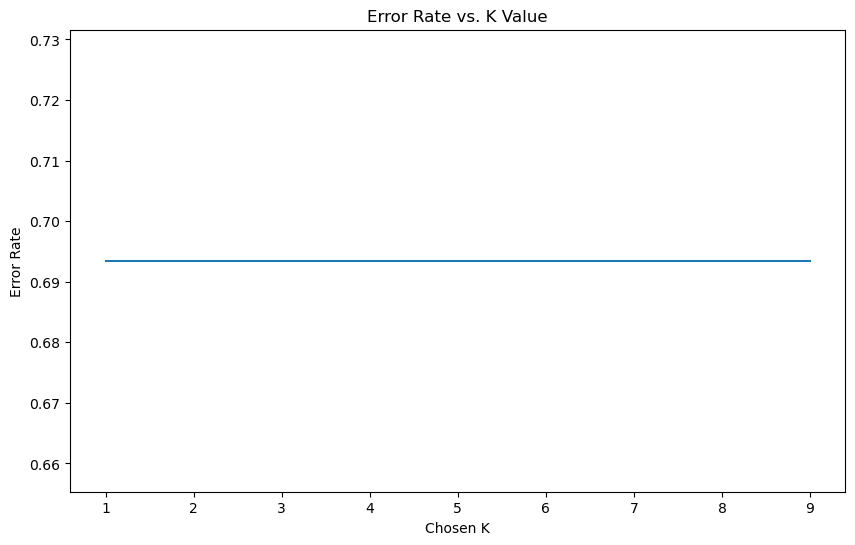

In [6]:
# Supress warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# KNN
error_rate = []

ks=10
for i in tqdm(range(1,ks)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    prediction_n = knn.predict(X_test)
    error_rate.append(np.mean(prediction_n != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,ks), error_rate)
plt.title('Error Rate vs. K Value')
plt.xlabel('Chosen K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate), "at K =", error_rate.index(min(error_rate)))
# Best K is 1

In [7]:
# Now we use optimal K to find accuracy
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {knn_accuracy}")

# Random forest
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rf_accuracy}")

# Decision three
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {dt_accuracy}")

# SVM
svm = SVC(kernel='linear', C=1, random_state=1)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {svm_accuracy}")

# Logistic Regress
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {lr_accuracy}")

Accuracy: 0.3065326633165829
Accuracy: 0.8894472361809045
Accuracy: 0.8140703517587939
Accuracy: 0.9396984924623115
Accuracy: 0.9296482412060302


# Weighted voting 
Using accuracy as weights 

In [8]:
# Params
models = [('knn', knn),
          ('rf', rf),
          ('dt', dt),
          ('svm', svm),
          ('lr', lr)]

weights = [knn_accuracy, rf_accuracy, dt_accuracy, svm_accuracy, lr_accuracy]

# Hard voting
ensemble_hard = VotingClassifier(estimators=models, weights=weights, voting='hard')
ensemble_hard = ensemble_hard.fit(X_train, y_train)
ensemble_hard_pred = ensemble_hard.predict(X_test)
hard_accuracy = accuracy_score(y_test, ensemble_hard_pred)
print(f"Accuracy hard voting: {hard_accuracy}")

# Soft voting
# Updated params
models = [('knn', knn),
          ('rf', rf),
          ('dt', dt),
          ('svm', SVC(probability=True)),
          ('lr', lr)]

ensemble_soft = VotingClassifier(estimators=models, weights=weights, voting='soft')
ensemble_soft = ensemble_soft.fit(X_train, y_train)
ensemble_soft_pred = ensemble_soft.predict(X_test)
soft_accuracy = accuracy_score(y_test, ensemble_soft_pred)
print(f"Accuracy soft voting: {soft_accuracy}")

Accuracy hard voting: 0.9346733668341709
Accuracy soft voting: 0.9346733668341709


In [9]:
# Save model
from joblib import dump
dump(ensemble_soft, 'ensemble_soft_MDF_side.joblib') 
dump(ensemble_hard, 'ensemble_hard_MDF_side.joblib') 

['ensemble_hard_MDF_side.joblib']